In [1]:
## Your grade: 

# SLT-CE-4: Histogram Clustering

In this coding exercise you will apply histogram clustering (HC) in order to segment an image. You will implement two different methods (maximum a posterior (MAP) and deterministic annealing (DA)) in order to predict the clusters membership for each pixel.

<h2 style="background-color:#f0b375;"> References </h2>

<ol>
<li> Histogram clustering for unsupervised image segmentation: http://ieeexplore.ieee.org/document/784981/
</li>
<li> Lecture Slides 4: https://ml2.inf.ethz.ch/courses/slt/lectures/slt19_lecture04.pdf
</li>
<li> Lecture script: https://ml2.inf.ethz.ch/courses/slt/tutorials/SLT_Script.pdf
</li>
</ol>

<h2 style="background-color:#f0b375;"> Setup </h2>

In [2]:
import sklearn as skl
import matplotlib.pyplot as plt
import numpy as np

from sklearn.utils.validation import check_is_fitted
from matplotlib.image import imread

from sklearn.feature_extraction import image
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.utils.multiclass import unique_labels
from sklearn.cluster import KMeans
from scipy.stats import entropy
import random

## Texture and corresponding label map
(This texture is used to fit your model.)

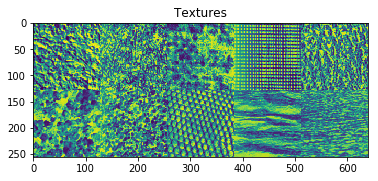

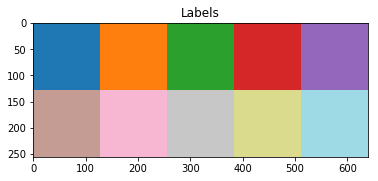

In [3]:
texture = imread("texture.png")

patch_grid_shape = (2,5)
patch_shape = (128,128)
label_map = np.ones(texture.shape)
for patch in range(np.prod(patch_grid_shape)):
    i, j = np.unravel_index(patch, patch_grid_shape)
    label_map[patch_shape[0] * i : patch_shape[0] * (i + 1), \
              patch_shape[1] * j : patch_shape[1] * (j + 1)] = np.ravel_multi_index((i,j), patch_grid_shape)

plt.imshow(texture)
plt.title("Textures")
plt.figure()
plt.imshow(label_map, cmap="tab20")
plt.title("Labels")
plt.show()

## Permuted texture and label map
(The permuted texture is used for the prediction)

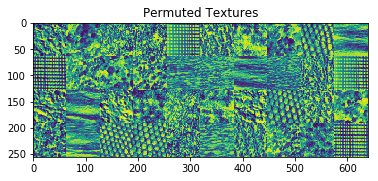

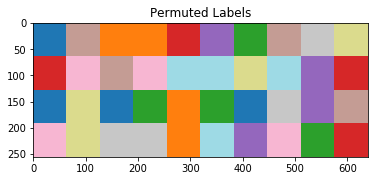

In [4]:
perm_patch_grid_shape = tuple(i * 2 for i in patch_grid_shape)
perm_patch_shape = tuple(i//2 for i in patch_shape)
n_perm_patches = np.prod(patch_grid_shape) * 4

np.random.seed(5)
perm = np.random.permutation(n_perm_patches)

perm_texture = np.ones(texture.shape)
perm_label_map = np.ones(texture.shape)

for patch, perm_patch in enumerate(perm):
    i, j = np.unravel_index(patch, perm_patch_grid_shape)
    ip, jp = np.unravel_index(perm_patch, perm_patch_grid_shape)
    
    perm_texture[ip * perm_patch_shape[0] : (ip + 1) * perm_patch_shape[0], \
                 jp * perm_patch_shape[1] : (jp + 1) * perm_patch_shape[1]] = \
    texture[i * perm_patch_shape[0] : (i + 1) * perm_patch_shape[0], \
            j * perm_patch_shape[1] : (j + 1) * perm_patch_shape[1]]
    
    perm_label_map[ip * perm_patch_shape[0] : (ip + 1) * perm_patch_shape[0], \
                   jp * perm_patch_shape[1] : (jp + 1) * perm_patch_shape[1]] = \
    label_map[i * perm_patch_shape[0] : (i + 1) * perm_patch_shape[0], \
              j * perm_patch_shape[1] : (j + 1) * perm_patch_shape[1]]
    
plt.imshow(perm_texture)
plt.title("Permuted Textures")
plt.figure()
plt.imshow(perm_label_map, cmap="tab20")
plt.title("Permuted Labels")
plt.show()

<h2 style="background-color:#f0b375;">
Section 4.0 
<span style=font-size:50%> Complete all problems in this section to get a pass on this exercise. </span>
</h2>

<p style="background-color:#adebad;">
    Read the references and recapitulate the parameter estimation formulas for both, Maximum a Posteriori estimation and Deterministic Annealing (DA) estimation. In particular, write down how equation (5) in reference [1] looks for the case of DA (using the notation of reference [1]). Hint: try to reformulate $\hat P(y|c)$ in terms of $\hat P(c|x)$ and use the maximum entropy principle to find an expression for $\hat P(c|x)$.
</p>

For the MAP estimation, we use the equation (5) and (6) provided in the paper with slight modifications, as we assume both pixels ($x$) and centroid histograms ($c$) are uniformly distributed. Under such assumptions, features given centroids are distributed as $\hat{P}(y|c)=\sum_\limits{x:\hat{c}(x)=c} \hat{P}(y|x)$ and the centroid assignments can be found as $\hat{c}(x) = \arg\min_a \left( -\sum_{y\in Y} \hat{P}(y|x)\log\hat{P}(y|a) \right)$.

In the case of DA, equation (5) becomes $\hat{P}(y|c)=\frac{\sum_{x\in X} \hat{P}(y|x) \mathbf{P}_{xc}}{\sum_{x\in X} \mathbf{P}_{xc}}$, where $\mathbf{P}_{xc}$ is the fuzzy assignments denoting the assignment probability of an object $x$ to a centroid $c$. Assignment probabilities are calculated as follows: $\mathbf{P}_{xc} = \frac{\exp(-D_{kl}(\hat{P}(y|x) || \hat{P}(y|c))/T)}{\sum_{\mu=1}^K \exp(-D_{kl}(\hat{P}(y|x) || \hat{P}(y|\mu))/T)}$, where the Kullback-Leibler divergence is calculated as $D_{kl}(\hat{P}(y|x) || \hat{P}(y|c)) = \sum_{i=1}^m \hat{P}(y_i|x) \log\frac{\hat{P}(y_i|x)}{\hat{P}(y_i|c)}$. Derivations of the update steps for deterministic annealing can be found [here](https://ml2.inf.ethz.ch/courses/slt/lectures/slt19_lecture04_derivation.pdf).

In MAP estimation we use hard assignments to attach objects to centroids. Each object is assigned to one and only one centroid. Under our assumptions we calculate the centroid histograms by simply averaging over all histograms of objects assigned to that particular centroid. Things are different in the DA estimation. There we use probabilistic (or so-called fuzzy/soft) assignments to attach objects to centroids. Each object is assigned to each cluster by some probability, which sums up to one for an individual object. Analogous to what we have did before, we average the object histograms to obtain the centroid histograms, only this time, weighting each object by its assignment probability and then normalizing over the sum of the probabilities for that centroid.

Function for plotting the confusion matrix is adapted from [here](https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html). Matching function permutes a given clustering solution accordingly to a reference clustering so the labels for the similar clusters match each other. Both fit and predict functions are extended to take hists as arguments for speeding up the function if the repsective histograms are calculated before. Similarly, DA estimation can be inputted with test_hists so that it can output its predictions after each iteration over temperature. User should note that prediction for DA estimation also needs temperature as input.

In [5]:
def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
        pass
    else:
        #print('Confusion matrix, without normalization')
        pass

    #print(cm)

    fig, ax = plt.subplots(figsize=(6,6))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax, shrink=0.7)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes, title=title, ylabel='True label', xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), ha="right", rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt), ha="center", va="center", color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [6]:
def match_maps(refmap, mymap, n_clusters):
    org_shape = mymap.shape
    refmap = np.reshape(refmap, (-1,))
    mymap = np.reshape(mymap, (-1,))
    ids = {}    
    new_map = {}
    commons_mat = np.zeros((n_clusters, n_clusters), dtype=int)
    for c in range(0, n_clusters):
        myid = np.where(mymap == c)[0]
        ids[c] = myid
        commons = [np.intersect1d(myid, np.where(refmap == i)[0]).size for i in range(0, n_clusters)]
        commons_mat[c,:] = commons
    for c in range(0, n_clusters):
        max_match = np.unravel_index(commons_mat.argmax(), commons_mat.shape)
        new_map[max_match[0]] = max_match[1]
        commons_mat[max_match[0],:] = -1
        commons_mat[:,max_match[1]] = -1
    copymap = mymap.copy()
    for c in range(0, n_clusters):
        copymap[ids[c]] = new_map[c]
    return np.reshape(copymap, org_shape), new_map

In [28]:
class HistogramClustering(skl.base.BaseEstimator, skl.base.TransformerMixin):
    """Template class for HistogramClustering (HC)
    
    Attributes:
        centroids (np.ndarray): Array of centroid distributions p(y|c) with shape (n_clusters, n_bins).
        
    Parameters:
        n_clusters (int): Number of clusters (textures).
        n_bins (int): Number of bins used to discretize the range of pixel values found in input image X.
        window_size (int): Size of the window used to compute the local histograms for each pixel.
                           Should be an odd number larger or equal to 3.
        random_state (int): Random seed.
        estimation (str): Whether to use Maximum a Posteriori ("MAP") or
                          Deterministic Annealing ("DA") estimation.
    """
    
    def __init__(self, n_clusters=10, n_bins=128, window_size=15, random_state=47, estimation="MAP", 
                top_neighs=3, top_B=1, top_lambda=1e-6):
        self.n_clusters = n_clusters
        self.n_bins = n_bins
        self.window_size = window_size
        self.random_state = random_state
        self.estimation = estimation
        # Add more parameters, if necessary.
        self.top_neighs = top_neighs
        self.top_B = top_B
        self.top_lambda = top_lambda
    
    def get_patches(self, X, ws=None):
        ws = self.window_size if ws is None else ws
        " patches.shape: (n_pixels, self.window_size, self.window_size) "
        paddim = int(ws/2 - 0.5)
        padmat = ((paddim,paddim),(paddim,paddim))
        padded = np.lib.pad(X, padmat, 'constant', constant_values=((-1, -1),(-1, -1)))
        patches = image.extract_patches_2d(padded, (ws, ws))
        return patches
    
    def get_hist(self, patch, normalize=False):
        hist = np.histogram(patch[patch>-1], bins=np.linspace(0,1,self.n_bins+1))[0]
        return hist/np.sum(hist) if normalize else hist
    
    def topological_prior(self, assignments):    
        prior_patches = self.get_patches(assignments, ws=self.top_neighs)
        height = assignments.shape[0]
        width = assignments.shape[1]
        prior_patches = np.reshape(prior_patches, (height, width, self.top_neighs, self.top_neighs))
        H_mat = np.zeros((height, width))
        for i in range(0, height):
            for j in range(0, width):
                a_patch = prior_patches[i,j,:,:]
                paddim = int(self.top_neighs/2 - 0.5)
                patch_class = a_patch[paddim,paddim]
                A_x = np.count_nonzero(a_patch == patch_class)-1
                H_mat[i,j] = self.top_B - A_x
                if H_mat[i,j] < 0:
                    H_mat[i,j] = 0
        H_vals = np.zeros((self.n_clusters, 1))
        for cid in range(0, self.n_clusters):
            ass_c = np.where(assignments == cid)[0]
            H_c = np.sum(H_mat[assignments == cid])
            H_vals[cid] = H_c
        priors = np.exp(-self.top_lambda * H_vals)
        priors = priors/np.sum(priors)
        return priors
    
    def fit_MAP(self, X, hists):

        height = X.shape[0]
        width = X.shape[1]
        n_pixels = height * width

        # Calculate histograms
        if hists is None:
            patches = self.get_patches(X)
            hists = np.apply_along_axis(self.get_hist, 1, np.reshape(patches, (n_pixels, -1)), True)
        self.train_hists = hists

        # Initialize centroids as random
        self.centroids = np.random.rand(self.n_clusters, self.n_bins)
        self.centroids = np.divide(self.centroids, np.sum(self.centroids, axis=1)[:, np.newaxis])

        assignments = np.zeros((n_pixels, 1), dtype=int)
        cluster_sizes = np.zeros((self.n_clusters, 1), dtype=int)

        # Initialize assignments by assigning points to nearest centroid
        cost_mat = -np.matmul(hists, np.log(self.centroids).T)
        assignments = np.expand_dims(np.argmin(cost_mat, axis=1), axis=1)

        for cid in range(0, self.n_clusters):
            cs = np.where(assignments == cid)[0].size
            cluster_sizes[cid] = cs

        epoch = 0
        while True:

            epoch = epoch+1
            change = False
            old_ass = assignments.copy()

            # Equation 5, calculate centroid histograms
            for cid in range(0, self.n_clusters):
                xids = np.where(assignments == cid)[0]
                # (also calculate centroid probabilities)
                cluster_sizes[cid] = xids.size
                if xids.size == 0:
                    print('Empty cluster')
                self.centroids[cid] = np.mean(hists[xids], axis=0)
            # Add a minuscule non-zero value for numerical stability
            self.centroids = self.centroids + 1e-8

            # Equation 6, calculate pixel assignments
            assignments = np.reshape(assignments, (-1, 1))
            cost_mat = -np.matmul(hists, np.log(self.centroids).T)
            priors = np.squeeze(self.topological_prior(assignments))
            # cost_mat = cost_mat - np.log(priors)
            # cluster_probas = np.squeeze(cluster_sizes/np.sum(cluster_sizes))
            assignments = np.expand_dims(np.argmin(cost_mat, axis=1), axis=1)
            if np.sum(assignments - old_ass) != 0:
                change = True

            if not change:
                break

        self.centroids = np.divide(self.centroids, np.sum(self.centroids, axis=1)[:, np.newaxis])
        return self
    
    def fit_DA(self, X, hists, test_hists=None):

        height = X.shape[0]
        width = X.shape[1]
        n_pixels = height * width

        # Calculate histograms
        if hists is None:
            patches = self.get_patches(X)
            hists = np.apply_along_axis(self.get_hist, 1, np.reshape(patches, (n_pixels, -1)), True)
        self.train_hists = hists

        # Initialize centroids
        init_center = np.mean(hists, axis=0)
        self.centroids = np.repeat(init_center[np.newaxis,:], self.n_clusters, axis=0)
        self.centroids = np.divide(self.centroids, np.sum(self.centroids, axis=1)[:, np.newaxis])
        
        # Initialize probabilities
        p = np.ones((n_pixels, self.n_clusters), dtype='float32') / self.n_clusters
        #pc_list = np.ones((self.n_clusters,1), dtype='float32') / self.n_clusters
        p_x = 1.0 / n_pixels

        # Initial temperature
        T = 0.3
        # T_min for stopping the algorithm
        self.T_cutoff = 0.17
        # For the final calculation
        self.T_zero = 10e-3
        # Epsilon for closeness check
        epsilon = 0.002
        # Cooling rate
        alpha = 0.9
        
        while True:
            print('T =', T)
            
            # Perturb centroids if too close to each other
            for i in range(0, self.n_clusters):
                for j in range(0, self.n_clusters):
                    if i != j and np.linalg.norm(self.centroids[i] - self.centroids[j]) < epsilon:
                        noise = np.random.normal( scale=epsilon, size=self.centroids[j].shape )
                        #self.centroids[j] = self.centroids[j] + np.random.normal(0, .1, self.centroids[j].shape)
                        self.centroids[j] = self.centroids[j] + noise
                        self.centroids[j][ self.centroids[j] < 0 ] = np.abs( self.centroids[j][ self.centroids[j] < 0 ] )
                        self.centroids[j][ self.centroids[j] >  1 ] = 2 - self.centroids[j][ self.centroids[j] >  1 ]
            self.centroids = np.divide(self.centroids, np.sum(self.centroids, axis=1)[:, np.newaxis])
            
            while True:
                # p: (n_pixels, n_clusters)
                # hists: (n_pixels, n_bins)
                # p[:,k]: (n_pixels, )
                
                old_centroids = self.centroids.copy()
                
                # Expectation step, centroids are fixed
                '''
                # Iterative version:
                kls = []
                for k in range(0, self.n_clusters):
                    div = np.divide(hists, self.centroids[k] + 10e-4)
                    temp = np.multiply(hists, np.log(div + 10e-10))
                    kl = -np.sum(temp, axis=1) / T
                    kls.append(kl)
                '''
                # Vectorised version:
                kls = np.array([-np.sum(np.multiply(hists, np.log(np.divide(hists, k + 10e-4) + 10e-10)), axis=1) / T 
                       for k in self.centroids])
                #kls = kls - np.max(kls, axis=0)
                kls = np.exp(kls)
                p = np.moveaxis(kls/np.sum(kls, axis=0), 0, 1) 
                
                # Maximization step, assignments are fixed
                '''
                # Iterative version:
                for k in range(0, self.n_clusters):
                    nom = np.sum(hists * p[:,k][:,np.newaxis], axis=0)
                    denom = np.sum(p[:,k])
                    print(denom)
                    self.centroids[k] = nom / denom
                '''
                # Vectorised version:
                nom = np.matmul(p.T, hists)
                denom = np.sum(p, axis=0)[:,np.newaxis]
                self.centroids = nom / denom
                self.centroids = np.divide(self.centroids, np.sum(self.centroids, axis=1)[:, np.newaxis])
                    
                # diffs = np.linalg.norm(old_centroids - self.centroids)
                diffs = np.sqrt(np.sum(np.power(old_centroids - self.centroids, 2)))
                if diffs < 1e-4:
                    break

            # Show predictions after each EM convergence
            if(True):
                train_pred = self.predict(X, hists, T=T)
                matched_preds = match_maps(label_map, train_pred, 10)[0]
                plt.figure(figsize=(16,4))
                plt.subplot(121)
                plt.imshow(label_map, cmap="tab20")
                plt.subplot(122)
                plt.imshow(matched_preds, cmap="tab20")
                plt.show()
            
                if test_hists is not None:
                    test_pred = self.predict(X, test_hists, T=T)
                    matched_preds = match_maps(perm_label_map, test_pred, 10)[0]
                    plt.figure(figsize=(16,4))
                    plt.subplot(121)
                    plt.imshow(perm_label_map, cmap="tab20")
                    plt.subplot(122)
                    plt.imshow(matched_preds, cmap="tab20")
                    plt.show()

            if T == self.T_zero:
                return self
            elif T < self.T_cutoff:
                T = self.T_zero
            else:
                T = alpha * T
    
    def fit(self, X, hists=None, test_hists=None):
        """Compute HC for input image X
        
        Compute centroids.        
        
        Args:
            X (np.ndarray): Input array with shape (height, width)
        
        Returns:
            self
        """
        random.seed(self.random_state)
        np.random.seed(self.random_state)
        
        if self.estimation == "MAP":
            
            # Code for Maximum a Posteriori estimation
            self.fit_MAP(X, hists)
        
        elif self.estimation == "DA":
            
            # Code for Deterministic Annealing estimation
            self.fit_DA(X, hists, test_hists)
        
        return self
    
    def predict(self, X, hists=None, T=None):
        """Predict cluster assignments for each pixel in image X.
        
        Args:
            X (np.ndarray): Input array with shape (height, width)
            
        Returns:
            C (np.ndarray): Assignment map (height, width) 
        """
        check_is_fitted(self, ["centroids"])
        
        height = X.shape[0]
        width = X.shape[1]
        n_pixels = height * width

        # Calculate histograms
        if hists is None:
            patches = self.get_patches(X)
            hists = np.apply_along_axis(self.get_hist, 1, np.reshape(patches, (n_pixels, -1)), True)
            self.test_hists = hists

        if self.estimation == "MAP":
            cost_mat = -np.matmul(hists, np.log(self.centroids).T)
            assignments = np.expand_dims(np.argmin(cost_mat, axis=1), axis=1)
            C = np.reshape(assignments, (height, width))
        if self.estimation == "DA":
            if T is None:
                T = self.T_zero
            kls = np.array([-np.sum(np.multiply(hists, np.log(np.divide(hists, k + 10e-4) + 10e-10)), axis=1) / T 
                   for k in self.centroids])
            #kls = kls - np.max(kls, axis=0)
            kls = np.exp(kls)
            p = np.moveaxis(kls/np.sum(kls, axis=0), 0, 1)
            assignments = np.argmax(p, axis=1)
            C = np.reshape(assignments, (height, width))

        return C
    
    def generate(self, C):
        """Generate a sample image X from a texture label map C.
        
        The entries of C are integers from the set {1,...,n_clusters}. They represent the texture labels
        of each pixel. Given the texture labels, a sample image X is generated by sampling
        the value of each pixel from the fitted p(y|c).
        
        Args:
            C (np.ndarray): Input array with shape (height, width)
            
        Returns:
            X (np.ndarray): Sample image (height, width)
        """
        check_is_fitted(self, ["centroids"])
        
        # Your code goes here
        
        X = np.zeros(C.shape)
        height = patch_shape[0]
        width = patch_shape[1]
        discret = np.linspace(0, 1, self.n_bins+1)
        for h in range(0, height):
            for w in range(0, width):
                cs = np.cumsum(self.centroids[C[h,w]])
                choice = random.random()
                bin_idx = np.where(np.array(choice < cs, dtype=int) == 1)[0][0]
                X[h,w] = np.random.uniform(discret[bin_idx],discret[bin_idx+1],1)
        
        return X
        

<p style="background-color:#adebad;">
Implement the "MAP" part of the <b>fit method</b> for the template class HistogramClustering, according to the contract outlined in its docstring. You can add more class methods if necessary. Create an instance of your HC class with n_clusters = 10 and fit the image texture. Record the execution time.
</p>

In [18]:
%%time
HC = HistogramClustering()
HC.fit(texture)
check_is_fitted(HC, ["centroids"])

Wall time: 35.9 s


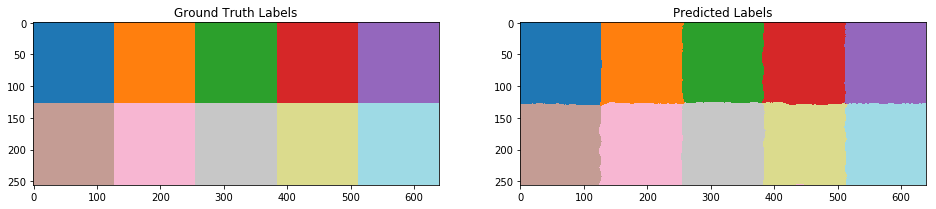

Accuracy: 0.9897216796875


In [19]:
# Prediction results on training data (permuted accordingly to the ground truth labels when plotting)
train_pred = HC.predict(texture, HC.train_hists)
matched_preds = match_maps(label_map, train_pred, 10)[0]
plt.figure(figsize=(16,4))
plt.subplot(121)
plt.imshow(label_map, cmap="tab20")
plt.title("Ground Truth Labels")
plt.subplot(122)
plt.imshow(matched_preds, cmap="tab20")
plt.title("Predicted Labels")
plt.show()
# Train accuracy
y_true = np.array(np.reshape(label_map, (-1,)), dtype=int)
y_pred = np.array(np.reshape(matched_preds, (-1,)), dtype=int)
print('Accuracy:', accuracy_score(y_true, y_pred))

<h2 style="background-color:#f0b375;">
Section 4.5 
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 4.5 </span>
</h2>

<p style="background-color:#adebad;">
    <ul style="background-color:#adebad;">
        <li> Implement the <b>predict method</b> for the template class HC, according to the contract outlined in its docstring.
        </li>        
        <li>
            Use HC.predict to predict the texture labels of perm_texture. Plot the predicted label map.
        </li>
    </ul>
</p>

In [20]:
%%time
predicted_perm_label_map = HC.predict(perm_texture)

Wall time: 11.4 s


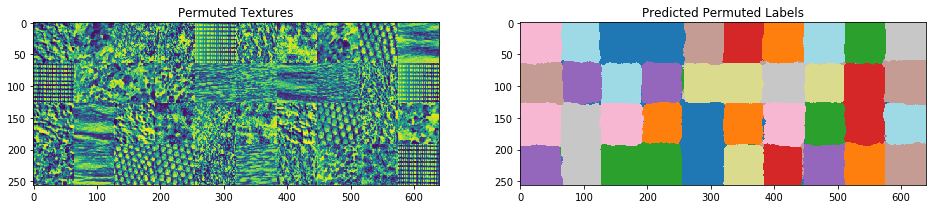

In [21]:
# Plot of predicted label map
plt.figure(figsize=(16,4))
plt.subplot(121)
plt.imshow(perm_texture)
plt.title("Permuted Textures")
plt.subplot(122)
plt.imshow(predicted_perm_label_map, cmap="tab20")
plt.title("Predicted Permuted Labels")
plt.show()

We use our match_maps function to permute label assignments so that same cluster ids refer to same clusters in the ground truth and our predictions. This is necessary for plotting the confusion matrix and calculating the accuracy, but it is also useful if we are to compare the predicted labels and the ground truth side by side, as seen below.

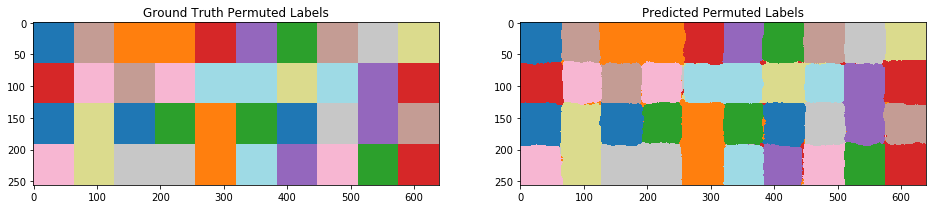

In [22]:
matched_preds = match_maps(perm_label_map, predicted_perm_label_map, 10)[0]
plt.figure(figsize=(16,4))
plt.subplot(121)
plt.imshow(perm_label_map, cmap="tab20")
plt.title("Ground Truth Permuted Labels")
plt.subplot(122)
plt.imshow(matched_preds, cmap="tab20")
plt.title("Predicted Permuted Labels")
plt.show()

<p style="background-color:#adebad;">
    Plot a confusion matrix for your predictions, using the perm_label_map. Make sure to permute the texture labels appropriately, so that they are in correpondence with the true labels.
</p>

Accuracy: 0.964990234375


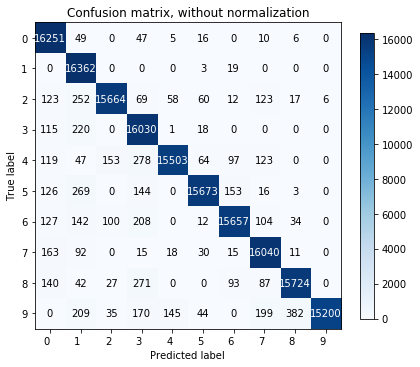

In [23]:
# Confusion matrix
y_true = np.array(np.reshape(perm_label_map, (-1,)), dtype=int)
y_pred = np.array(np.reshape(matched_preds, (-1,)), dtype=int)
plot_confusion_matrix(y_true, y_pred, np.arange(10), normalize=False)
print('Accuracy:', accuracy_score(y_true, y_pred))

<p style="background-color:#adebad;">
    Using n_clusters=10, fit HC with all combinations of n_bins = 16, 32, 64 and window_size = 7, 9, 11.
    For each setting compute the accuracy of the prediction on perm_texture. Show the results in a 3x3 matrix and label the axes properly.
</p>

In [55]:
# 3x3 Matrix with accuracy scores of the different parameter combination
results = []
bin_lst = [16,32,64]
wnd_lst = [7,9,11]
acc_mat = np.zeros((len(wnd_lst), len(bin_lst)))
for ib, n_bins in enumerate(bin_lst):
    for iw, window_size in enumerate(wnd_lst):
        HC = HistogramClustering(n_bins=n_bins, window_size=window_size)
        HC.fit(texture)
        predicted_perm_label_map = HC.predict(perm_texture)
        matched_preds = match_maps(perm_label_map, predicted_perm_label_map, 10)[0]
        y_true = np.array(np.reshape(perm_label_map, (-1,)), dtype=int)
        y_pred = np.array(np.reshape(matched_preds, (-1,)), dtype=int)
        acc = accuracy_score(y_true, y_pred)
        acc_mat[iw,ib] = acc
        print(n_bins, window_size, acc)
        results.append([n_bins, window_size, matched_preds])

16 7 0.245709228515625
16 9 0.276318359375
16 11 0.3015380859375
32 7 0.3066650390625
32 9 0.365777587890625
32 11 0.336553955078125
64 7 0.444879150390625
64 9 0.557220458984375
64 11 0.646417236328125


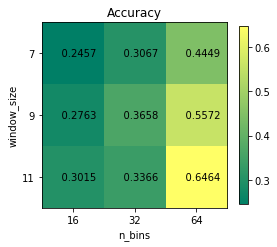

In [56]:
fig, ax = plt.subplots(figsize=(4,4))
im = ax.imshow(acc_mat, cmap="summer")
ax.figure.colorbar(im, ax=ax, shrink=0.7)

ax.set_xticks(np.arange(len(bin_lst)))
ax.set_yticks(np.arange(len(wnd_lst)))
ax.set_xticklabels(bin_lst)
ax.set_yticklabels(wnd_lst)

for i in range(len(wnd_lst)):
    for j in range(len(bin_lst)):
        text = ax.text(j, i, "{:10.4f}".format(acc_mat[i, j]), ha="center", va="center", color="k")

ax.set_title('Accuracy')
ax.set_xlabel('n_bins')
ax.set_ylabel('window_size')
fig.tight_layout()
plt.show()

Accuracy grows almost monotonically as we use more histogram bins and larger windows. This could be expected as smaller windows may fail to capture spatial locality and smaller number of bins could lead to huge information loss through coarse-grained discretization. However, this trend is not expected to hold as both variables grow bigger. Larger window sizes will begin to include more than the local information but instead will start being a global feature extractor, which is useless to discriminate local patches. Similarly using extremal number of bins may hinder the generalization capabilities of the histograms, making them practically adapt to fluctuations in the noise of pixel intensities. Results of the aforementioned configurations are illustrated below.

<p style="background-color:#adebad;">
    For each setting plot the prediction (i.e. the clustering) of the texture (perm_texture) itself. Arrange the plots next to each other in a grid and label them properly.
    </p>

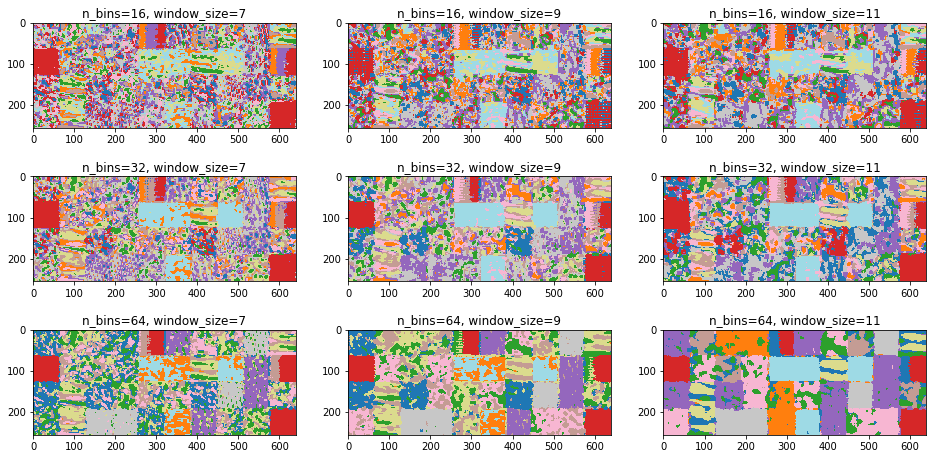

In [57]:
# Cluster predictions (9 plots arranged in a 3x3 grid)
plt.figure(figsize=(16,8))
for i in range(0,len(results)):
    n_bins, window_size, matched_preds = results[i]
    plt.subplot(331+i)
    plt.imshow(matched_preds, cmap="tab20")
    plt.title('n_bins=' + str(n_bins) + ', ' + 'window_size=' + str(window_size))
plt.show()

<h2 style="background-color:#f0b375;">
Section 5 
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 5 </span>
</h2>

<ul style="background-color:#adebad;">
        <li> Implement the <b>generate method</b> for the template class HC, according to the contract outlined in its docstring.
        </li>
        <li>
        Use HC.generate to generate ten 128x128 patches, one for each texture. Plot the generated textures next to the ground truth textures.
        </li>
    </ul>

In [58]:
HC = HistogramClustering(n_bins=32)
HC.fit(texture)

HistogramClustering(estimation='MAP', n_bins=32, n_clusters=10,
          random_state=47, top_B=1, top_lambda=1e-06, top_neighs=3,
          window_size=15)

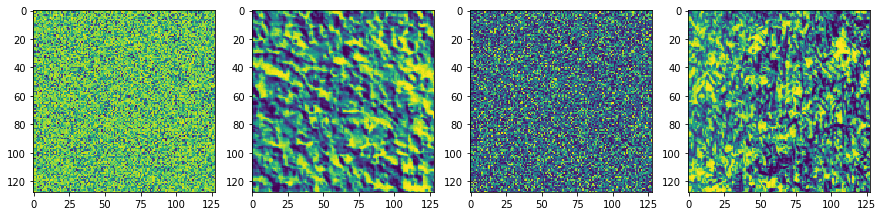

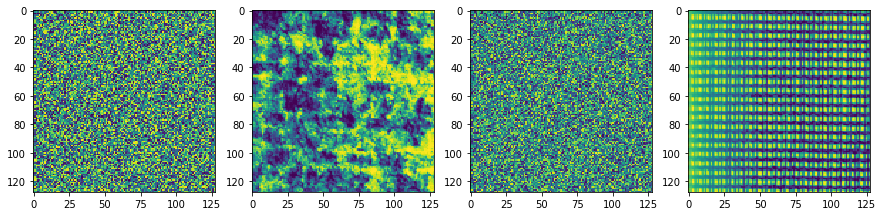

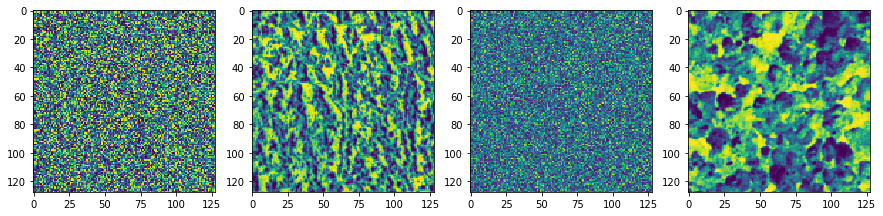

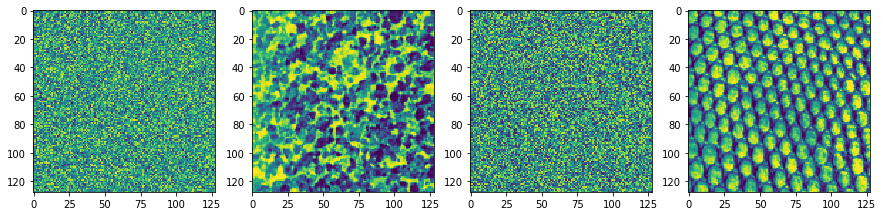

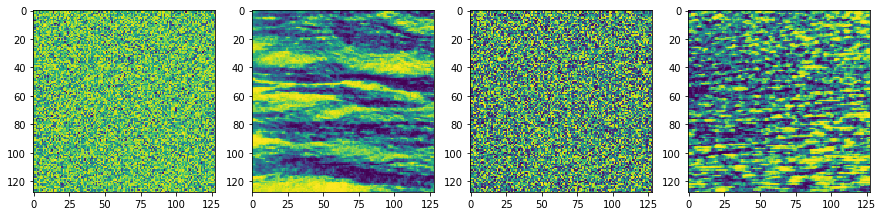

In [59]:
orgs = []
gens= []

for patch in range(np.prod(patch_grid_shape)):
    i, j = np.unravel_index(patch, patch_grid_shape)
    org_patch = texture[patch_shape[0] * i : patch_shape[0] * (i + 1), \
              patch_shape[1] * j : patch_shape[1] * (j + 1)]

    C = np.ones(patch_shape, dtype=int) * patch
    gen_patch = HC.generate(C)
    
    orgs.append(org_patch)
    gens.append(gen_patch)

for i in range(0, len(orgs), 2):
    plt.figure(figsize=(15,15))
    plt.subplot(141)
    plt.imshow(gens[i])
    plt.subplot(142)
    plt.imshow(orgs[i])
    plt.subplot(143)
    plt.imshow(gens[i+1])
    plt.subplot(144)
    plt.imshow(orgs[i+1])
    plt.show()

<h2 style="background-color:#f0b375;">
Section 5.5 
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 5.5 </span>
</h2>

<ul style="background-color:#adebad;">
    <li>
        Use k-means clustering to cluster the pixels of the texture (perm_texture). Set n_clusters=10, and use the local histogram vectors as features. Compare the predicted label map with k-means with the predicted label map obtained by HC.
    </li>
</ul>

In [29]:
HC_MAP = HistogramClustering()
HC_MAP.fit(texture)
predicted_perm_label_map_HC_MAP = HC_MAP.predict(perm_texture)

In [30]:
kmeans = KMeans(n_clusters=10, random_state=0).fit(HC_MAP.train_hists)
predicted_perm_label_map_km = np.reshape(kmeans.predict(HC_MAP.test_hists), perm_label_map.shape)

In [31]:
matched_preds_HC_MAP, hc_map = match_maps(perm_label_map, predicted_perm_label_map_HC_MAP, 10)
y_pred_HC_MAP = np.array(np.reshape(matched_preds_HC_MAP, (-1,)), dtype=int)
matched_preds_km, km_map = match_maps(perm_label_map, predicted_perm_label_map_km, 10)
y_pred_km = np.array(np.reshape(matched_preds_km, (-1,)), dtype=int)

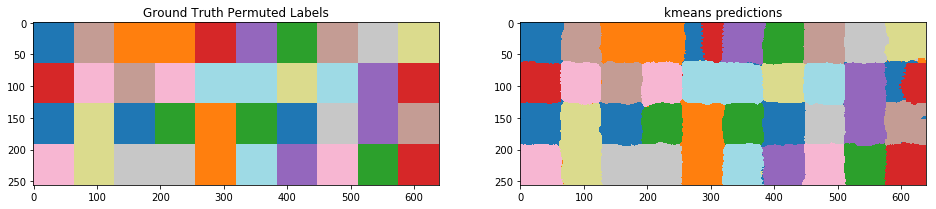

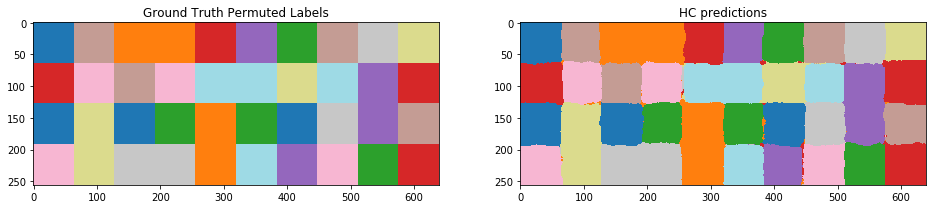

In [32]:
# Predicted label map for k-means
plt.figure(figsize=(16,4))
plt.subplot(121)
plt.imshow(perm_label_map, cmap="tab20")
plt.title("Ground Truth Permuted Labels")
plt.subplot(122)
plt.imshow(matched_preds_km, cmap="tab20")
plt.title("kmeans predictions")
plt.show()
# Predicted label map for HC
plt.figure(figsize=(16,4))
plt.subplot(121)
plt.imshow(perm_label_map, cmap="tab20")
plt.title("Ground Truth Permuted Labels")
plt.subplot(122)
plt.imshow(matched_preds_HC_MAP, cmap="tab20")
plt.title("HC predictions")
plt.show()

As seen above, kmeans and HC solutions are quite compatible with each other and the ground truth labels, aside from small artifacts in both.

<ul style="background-color:#adebad;">
    <li>
        Moreover, plot and compare the confusion matrices for both, K-means, and HC.
    </li>
</ul>

Accuracy: 0.96494140625


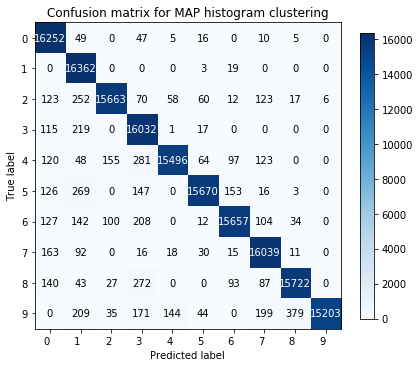

In [33]:
y_true = np.array(np.reshape(perm_label_map, (-1,)), dtype=int)
acc_HC_MAP = accuracy_score(y_true, y_pred_HC_MAP)
plot_confusion_matrix(y_true, y_pred_HC_MAP, np.arange(10), normalize=False, 
                      title='Confusion matrix for MAP histogram clustering')
print('Accuracy:', acc_HC_MAP)

Accuracy: 0.950628662109375


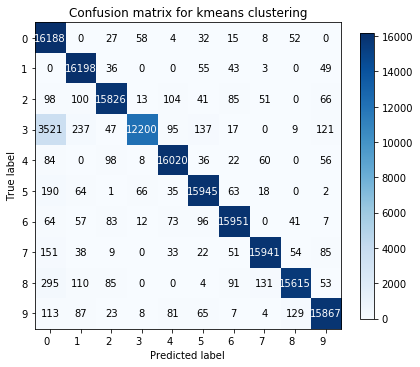

In [34]:
y_true = np.array(np.reshape(perm_label_map, (-1,)), dtype=int)
acc_km = accuracy_score(y_true, y_pred_km)
plot_confusion_matrix(y_true, y_pred_km, np.arange(10), normalize=False, title='Confusion matrix for kmeans clustering')
print('Accuracy:', acc_km)

<ul style="background-color:#adebad;">
        <li>
        Plot the centroid histograms $\hat P(y|c)$ after fitting the texture image. Compare them to the empirical histograms (i.e. show them both in one plot).
        </li>
    </ul>

Below, we plot the empirical histogram extracted from the image, alongside the matching kmeans and HC centroid histograms. This will hopefully give us a better intuition of understanding how well our solutions converged to the intended one and where do they make their mistakes. Histograms in each row refer to the label of the respective patch given in the first column of the plot. We again make use of our matching function to assign empirical histograms to centroids obtained from the algorithms.

In [38]:
km_rev = {}
for key, item in km_map.items():
    km_rev[item] = key
hc_rev = {}
for key, item in hc_map.items():
    hc_rev[item] = key

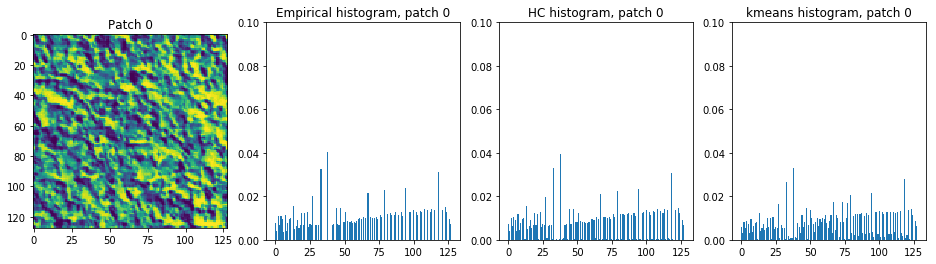

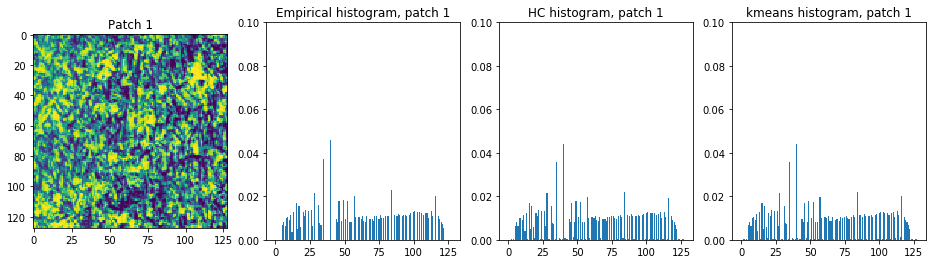

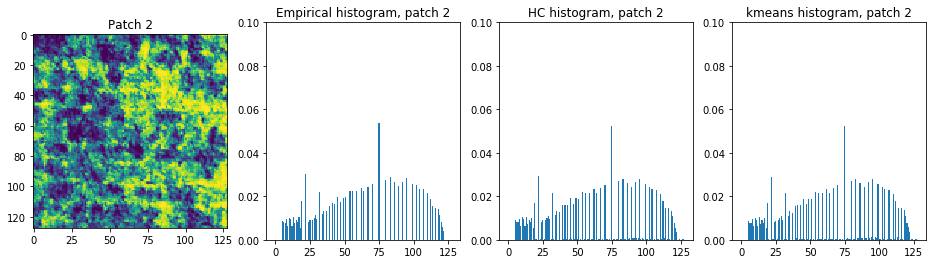

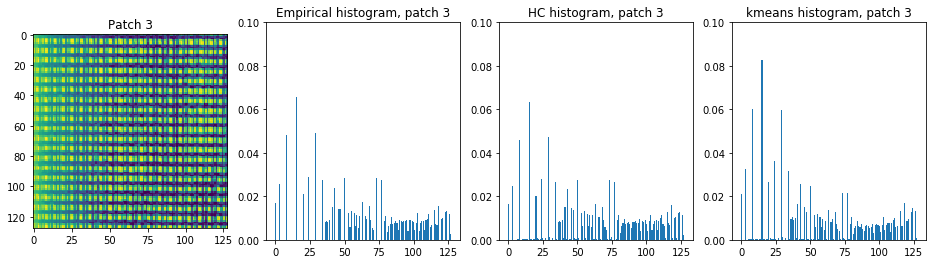

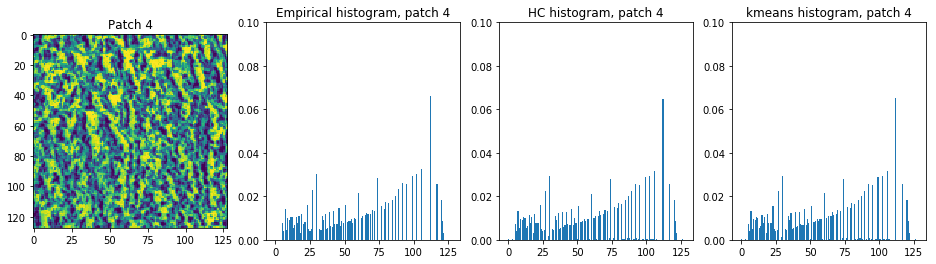

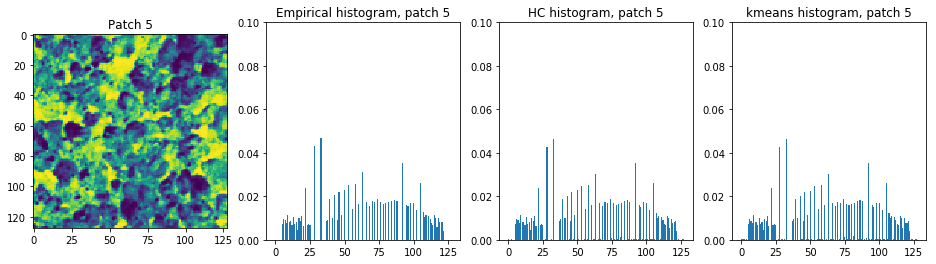

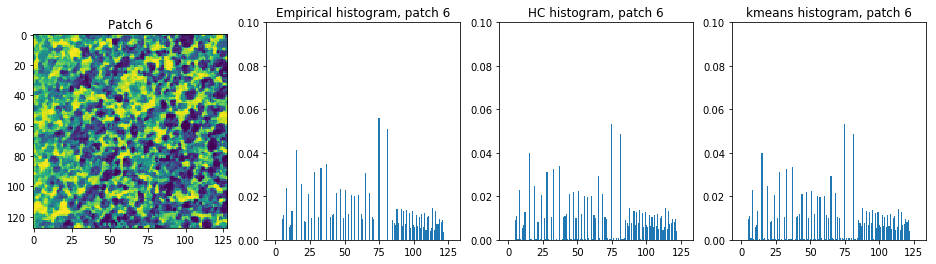

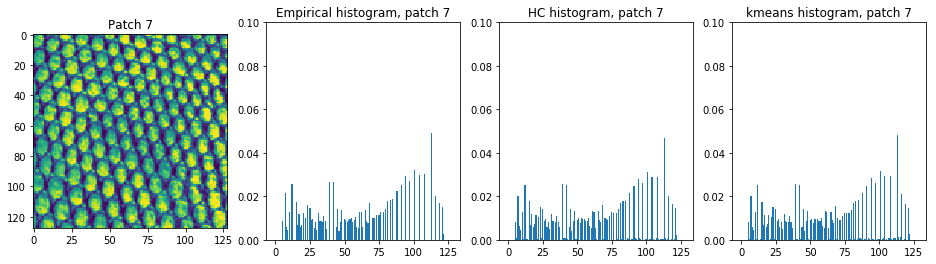

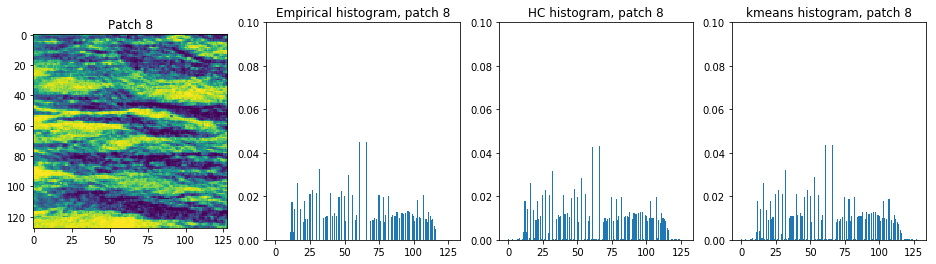

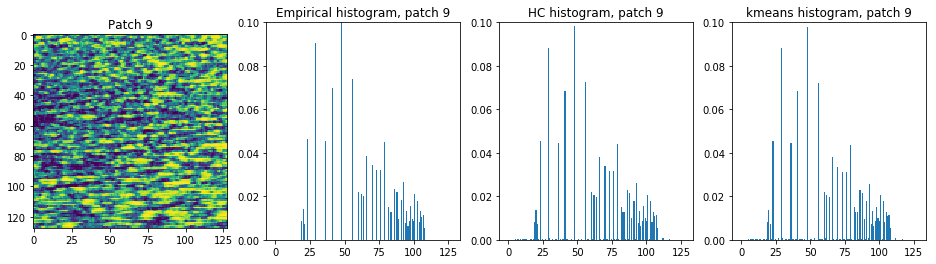

In [39]:
x = range(0, HC_MAP.n_bins)
for patch in range(np.prod(patch_grid_shape)):
    i, j = np.unravel_index(patch, patch_grid_shape)
    org_patch = texture[patch_shape[0] * i : patch_shape[0] * (i + 1), \
              patch_shape[1] * j : patch_shape[1] * (j + 1)]   

    org_hist = HC_MAP.get_hist(org_patch, normalize=True)
    hc_hist = HC_MAP.centroids[hc_rev[patch]]
    km_hist = kmeans.cluster_centers_[km_rev[patch]]
    
    plt.figure(figsize=(16,4))
    plt.subplot(141)
    plt.imshow(org_patch)
    plt.title("Patch " + str(patch))
    plt.subplot(142)
    plt.bar(x, org_hist)
    plt.ylim((0,0.1))
    plt.title("Empirical histogram, patch " + str(patch))
    plt.subplot(143)
    plt.bar(x, hc_hist)
    plt.ylim((0,0.1))
    plt.title("HC histogram, patch " + str(patch))
    plt.subplot(144)
    plt.bar(x, km_hist)
    plt.ylim((0,0.1))
    plt.title("kmeans histogram, patch " + str(patch))
    plt.show()

<h2 style="background-color:#f0b375;">
Section 6.0 
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 6.0 </span>
</h2>

<ul style="background-color:#adebad;">
        <li>
        Implement the "DA" part of HC.fit.
        </li>
    </ul>

Plots below show the clustering results on both training and test textures at each temperature, side by side with the ground truth labels. Our observations are in line with our expectations, as we have also seen how the deterministic annealing algorithm works in the previous coding exercise. We implement the deterministic annealing as sketched out in the pseudocode given in [lecture slides](https://ml2.inf.ethz.ch/courses/slt/lectures/slt19_lecture03.pdf), meaning we already initialize the algorithm with the desired number of cluster. However, depending on the temperature we may see a different number of effective clusters and only realize all of the clusters as we reduce the cool it down to sufficiently low temperatures. Reader should note that the referenced pseudocode is not for histogram clustering but instead for kmeans clustering, but the underlying idea is the same.

<ul style="background-color:#adebad;">
        <li>
        Plot the clustering (predicted labels) of the texture (perm_texture) at different temperatures. What can you observe?
        </li>
    </ul>

As stated above, different temperatures lead to different number of effective clusters, which monotonically increase as temperature drops down. Examining our results we can conclude the algorithm first learns the distinction between the cyan and teal clusters and the rest. Then, it completely isolates the cyan and divide the rest into two groups. Then it progressively separates all the clusters and lastly fine tunes the solution by removing some artifacts positioned by the texture borders. This procedure may hint at which clusters are similarly distributed and which are not (w.r.t. pixel intensities). Note that the specific orders and sizes of the clusters may differ in successive runs as the algorithm relies on some randomness.

T = 0.3


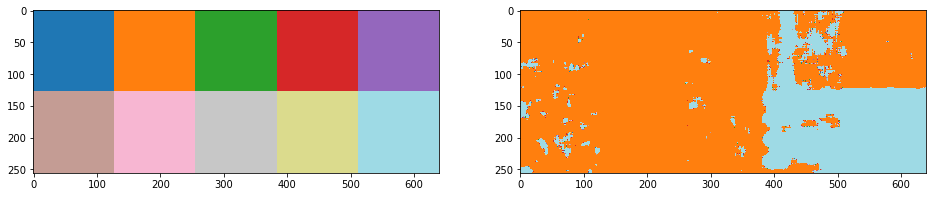

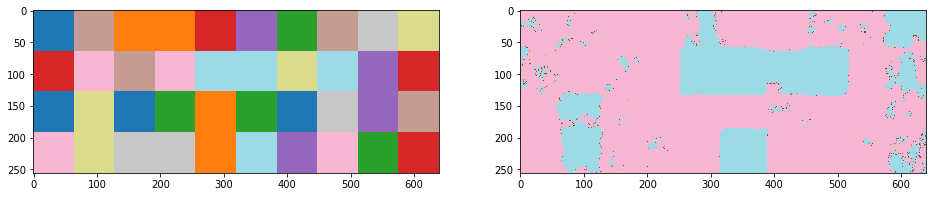

T = 0.27


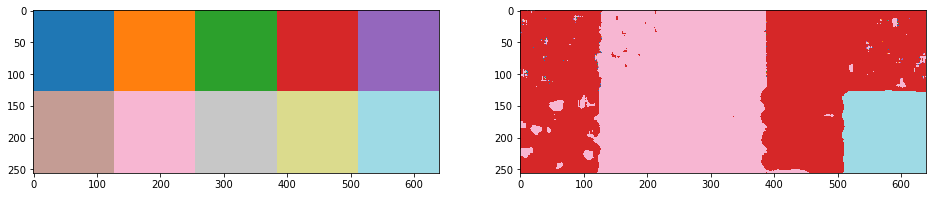

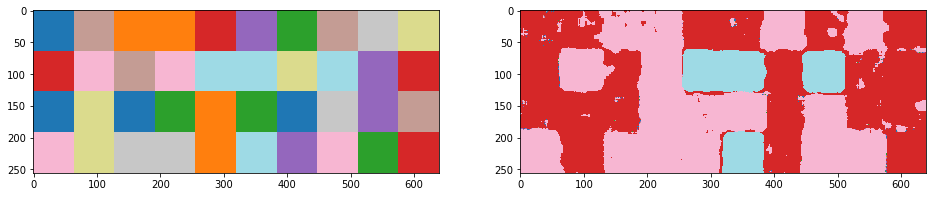

T = 0.24300000000000002


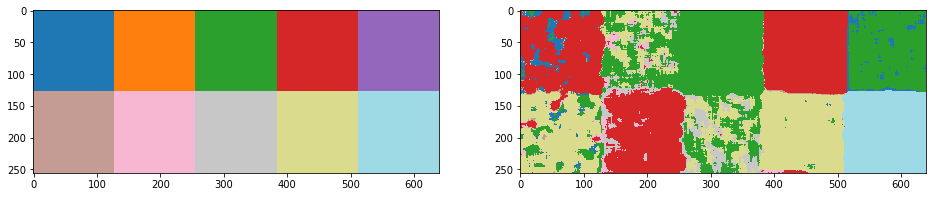

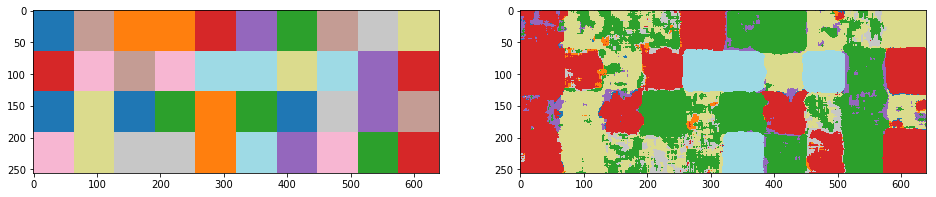

T = 0.21870000000000003


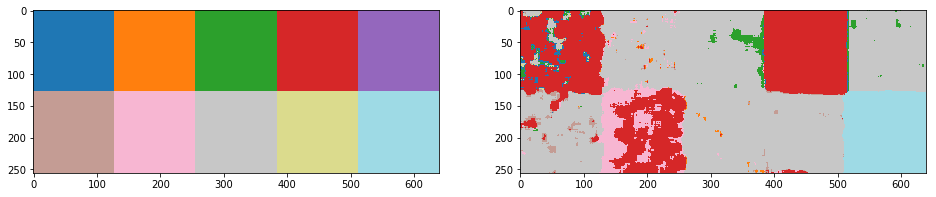

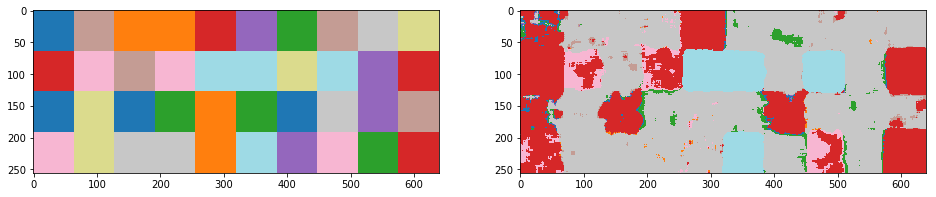

T = 0.19683000000000003


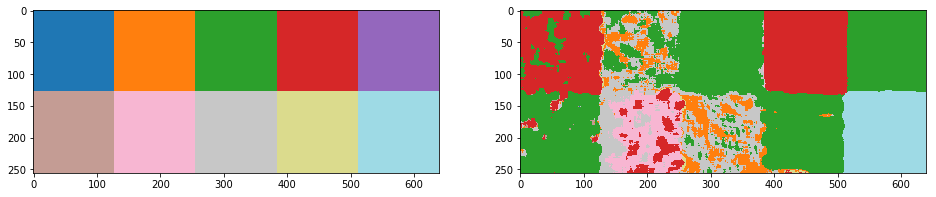

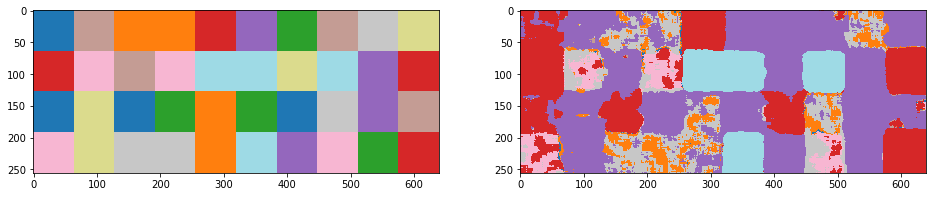

T = 0.17714700000000003


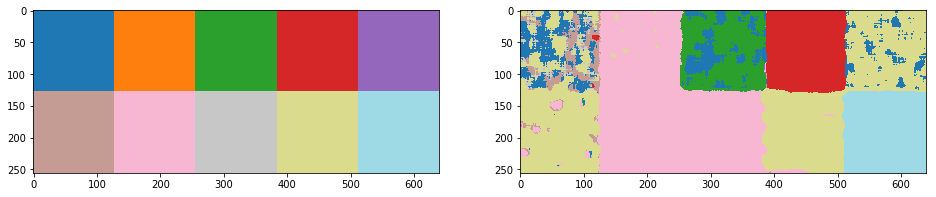

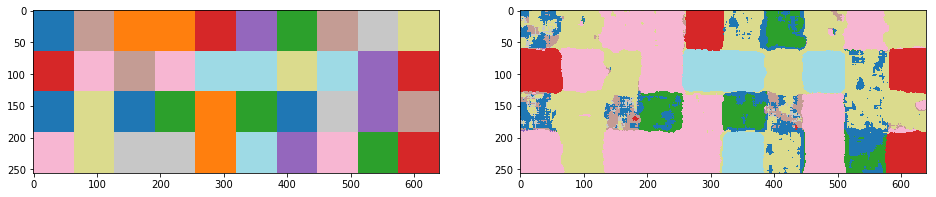

T = 0.15943230000000003


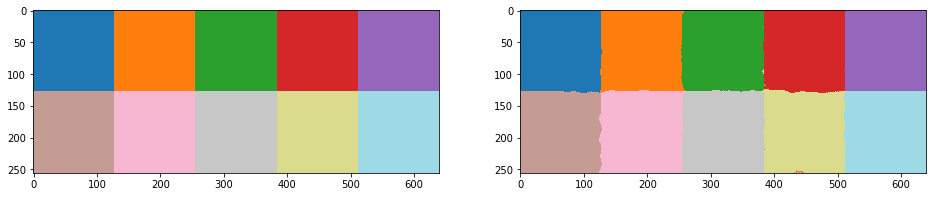

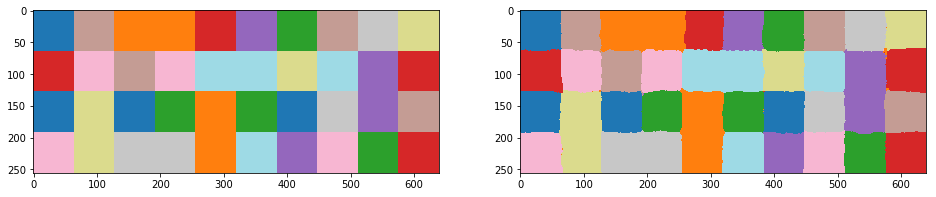

T = 0.01


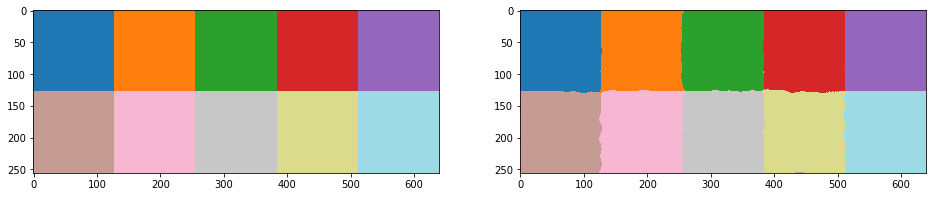

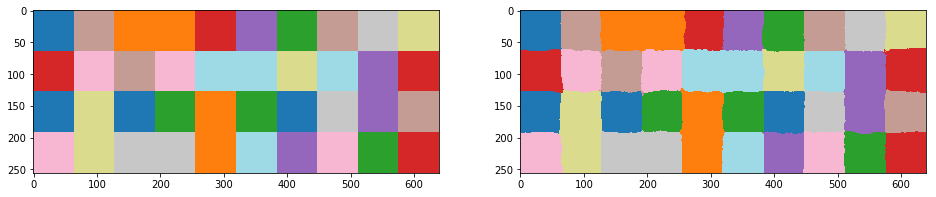

Wall time: 10min 29s


In [35]:
%%time
HC_DA = HistogramClustering(estimation="DA")
HC_DA.fit(texture, hists=HC_MAP.train_hists, test_hists=HC_MAP.test_hists)
check_is_fitted(HC_DA, ["centroids"])

We lastly provide a comparison of all solutions obtained so far: kmeans clustering, histogram clustering with maximum a posteriori estimation and histogram clustering with deterministic annealing for maximum entropy estimation. All three solutions are permuted to mathc the ground truth labels and plotted alongside the true solution.

In [36]:
predicted_perm_label_map_HC_DA = HC_DA.predict(perm_texture, HC_MAP.test_hists)
matched_preds_HC_DA, hc_map = match_maps(perm_label_map, predicted_perm_label_map_HC_DA, 10)
y_pred_HC_DA = np.array(np.reshape(matched_preds_HC_DA, (-1,)), dtype=int)

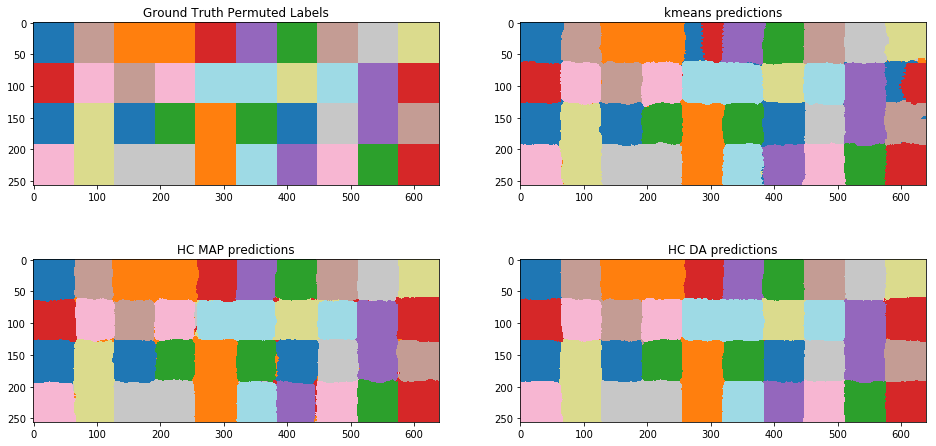

In [37]:
plt.figure(figsize=(16,8))
plt.subplot(221)
plt.imshow(perm_label_map, cmap="tab20")
plt.title("Ground Truth Permuted Labels")
plt.subplot(222)
plt.imshow(matched_preds_km, cmap="tab20")
plt.title("kmeans predictions")
plt.subplot(223)
plt.imshow(matched_preds_HC_MAP, cmap="tab20")
plt.title("HC MAP predictions")
plt.subplot(224)
plt.imshow(matched_preds_HC_DA, cmap="tab20")
plt.title("HC DA predictions")
plt.show()

Accuracy: 0.979449462890625


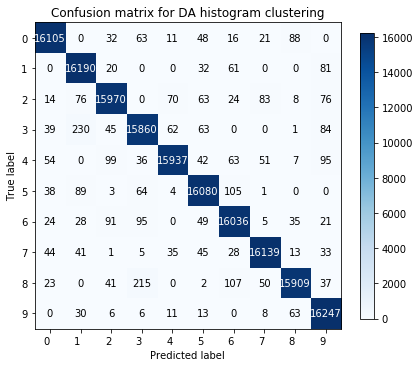

In [38]:
y_true = np.array(np.reshape(perm_label_map, (-1,)), dtype=int)
acc_HC_DA = accuracy_score(y_true, y_pred_HC_DA)
plot_confusion_matrix(y_true, y_pred_HC_DA, np.arange(10), normalize=False, 
                      title='Confusion matrix for DA histogram clustering')
print('Accuracy:', acc_HC_DA)

## Comments

We hope you found this exercise instructive.

Feel free to leave comments below, we will read them carefully.